In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fastai.tabular.all import *
from multiprocessing import Pool
from sklearn.model_selection import KFold, GroupKFold
import lightgbm as lgb
from optiver_features import *
import pickle

In [3]:
df = pd.read_csv('../input/optiver-realized-volatility-prediction/train.csv')
time_ids = df.time_id.unique()
np.random.seed(42)
np.random.shuffle(time_ids)

splt = int(len(time_ids)*.7)
train_ids, test_ids = time_ids[:splt], time_ids[splt:]

len(train_ids), len(test_ids)

(2681, 1149)

In [4]:
len(df[df.time_id.isin(train_ids)]) / len(df)

0.6999944047075061

## Generate 5m dataset

In [5]:
book_feature_dict = {
    wap1: [],
    wap2: [],
    log_return1: [np.std],
    log_return2: [np.std],
  
    price_spread:[np.mean],
    total_volume:[np.mean],
}
trade_feature_dict = {
        log_return_price: [np.std],
        'seconds_in_bucket':[np.size],
        'size':[np.sum],
        'order_count':[np.sum],
}
time_id_features=[]
time_id_aggregations = []
stock_id_features = []
stock_id_aggregations = [time_id_aggregations]
time_windows = [(0,300), (0,100), (100,200), (200,300)]

In [6]:
def generate_0_to_5():


    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
    train_df5m = ofg.generate_train_df()
    ofg_targ =OptiverFeatureGenerator({wap1:[], log_return1:[realized_volatility]}, {'seconds_in_bucket':[np.size]}, [(300,600)], [],[],[],[])
    targ_df = ofg_targ.generate_train_df()
    train_df5m.target = targ_df.log_return1_realized_volatility_300_600
    train_df5m.target = train_df5m.target.replace(0, 1e-4)
    return train_df5m
    

In [7]:
%%time
train_df5m = generate_0_to_5()

CPU times: user 2.56 s, sys: 817 ms, total: 3.37 s
Wall time: 5min 35s


In [8]:

train_df5m.to_feather('train_5m.feather')

In [9]:
def rename_col(x):
    return x.replace('300', '600').replace('200', '500').replace('100', '400').replace('_0', '_300')
def rename_col_back(x):
    return x.replace('300', '0').replace('400', '100').replace('500', '200').replace('600', '300')

def generate_5_to_10():
    tw = [(x+300, y+300) for x,y in time_windows]
    time_id_feat = [rename_col(x) for x in time_id_features]
    stock_id_feat = [rename_col(x) for x in stock_id_features]
    ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, tw, time_id_feat,time_id_aggregations, stock_id_feat, stock_id_aggregations)

    df = ofg.generate_train_df()
    df.columns = [rename_col_back(x) for x in df.columns]
    return df

In [10]:
train_df5_10m  = generate_5_to_10()

In [11]:
train_df5_10m.to_feather('train_5_10.feather')

In [12]:
cols_to_keep = ['log_return2_std_0_300',
 
 'stock_id','row_id', 'time_id', 'target',
 'log_return_price_std_0_300',
  'order_count_sum_0_300',
 'seconds_in_bucket_size_0_300',
 'size_sum_0_300',
 'log_return1_std_0_300',
 'log_return1_std_100_200',
 'log_return1_std_200_300',
 'price_spread_mean_0_300',

 'total_volume_mean_0_300']

In [13]:
train_df5m = train_df5m[cols_to_keep]
train_df5_10m = train_df5_10m[cols_to_keep]

## LGBM Baseline

In [14]:
def rmspe_np(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe_np(y_true, y_pred), False

def train_models(train):
    # Hyperparammeters (optimized)
    seed = 29
    params = {
        'learning_rate': 0.1,        
        'lambda_l1': 2,
        'lambda_l2': 7,
        'num_leaves': 800,
        'min_sum_hessian_in_leaf': 20,
        'feature_fraction': 0.8,
        'feature_fraction_bynode': 0.8,
        'bagging_fraction': 0.9,
        'bagging_freq': 42,
        'min_data_in_leaf': 700,
        'max_depth': 4,
        'seed': seed,
        'feature_fraction_seed': seed,
        'bagging_seed': seed,
        'drop_seed': seed,
        'data_random_seed': seed,
        'objective': 'rmse',
        'boosting': 'gbdt',
        'verbosity': -1,
        'n_jobs': -1,
    }   
    x = train
    # Split features and target
    for c in ['row_id', 'target', 'time_id']:
        if c in x.columns:
            x = x.drop(c, axis=1)
    
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    models =[]
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    kfold = GroupKFold()
    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(x, groups = train.time_id)):
        print(f'Training fold {fold + 1}')
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights, categorical_feature = ['stock_id'])
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights, categorical_feature = ['stock_id'])
        model = lgb.train(params = params, 
                          train_set = train_dataset, 
                          valid_sets = [train_dataset, val_dataset], 
                          num_boost_round = 3000, 
                          early_stopping_rounds = 25, 
                          verbose_eval = 100,
                          feval = feval_rmspe)
        models.append(model)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        # Predict the test set
        #test_predictions += model.predict(x_test) / 10
        
    rmspe_score = rmspe_np(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')
    # Return test predictions
    return models

In [15]:
_=train_models(train_df5m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000357779	training's RMSPE: 0.244754	valid_1's rmse: 0.000370922	valid_1's RMSPE: 0.254099
[200]	training's rmse: 0.000350515	training's RMSPE: 0.239785	valid_1's rmse: 0.000367952	valid_1's RMSPE: 0.252064
[300]	training's rmse: 0.000346728	training's RMSPE: 0.237194	valid_1's rmse: 0.000366881	valid_1's RMSPE: 0.251331
[400]	training's rmse: 0.000344141	training's RMSPE: 0.235424	valid_1's rmse: 0.000366172	valid_1's RMSPE: 0.250845
[500]	training's rmse: 0.000342541	training's RMSPE: 0.23433	valid_1's rmse: 0.000365864	valid_1's RMSPE: 0.250634
Early stopping, best iteration is:
[574]	training's rmse: 0.000340901	training's RMSPE: 0.233208	valid_1's rmse: 0.000365659	valid_1's RMSPE: 0.250493
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000358507	training's RMSPE: 0.244747	valid_1's rmse: 0.000372946	valid_1's RMSPE: 0.257576
[200]	training's

## Learning embeddings

In [48]:
cont_nn,cat_nn = cont_cat_split(train_df5m, max_card=9000, dep_var='target')
cat_nn = ['time_id', 'stock_id']


procs_nn = [Categorify, FillMissing,Normalize]

splits = RandomSplitter(valid_pct=0.1,seed=43)(train_df5m)

dls = TabularPandas(train_df5m, procs_nn, cat_nn, cont_nn,
                      splits=splits, 
                       
                      y_names='target').dataloaders(1024)

def rmse(preds, targs):
    x = (targs-preds)
    return (x**2).mean().sqrt()

def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

config={'lin_first':True, 'ps':[0,0,0], 'embed_p':0.25, }
learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,40], emb_szs={'stock_id':10, 'time_id':20}, 
                        n_out=1, 
                        loss_func = rmspe, 
                        
                        metrics=AccumMetric(rmspe), config=config)

In [49]:
learn.fit_one_cycle(30, 5e-3)

epoch,train_loss,valid_loss,rmspe,time
0,7.370855,5.542631,5.547337,00:05
1,1.039220,0.574142,0.585812,00:04
2,0.395199,0.301306,0.301528,00:04
3,0.295486,0.276157,0.276694,00:04
4,0.266894,0.249277,0.250706,00:05
5,0.249466,0.234310,0.234635,00:05
6,0.248440,0.300160,0.324276,00:04
7,0.244861,0.233210,0.233597,00:04
8,0.244758,0.231675,0.232056,00:03
9,0.245985,0.271197,0.271871,00:05


In [50]:
categorify = dls.procs[2]
time_embs = learn.model.embeds[0].weight.data.cpu()
stock_embs = learn.model.embeds[1].weight.data.cpu()

In [51]:
def append_embs(data_df, categorify, time_embs, stock_embs):
    time_id_embs = dict()
    for idx, time_id in enumerate(categorify.classes['time_id']):
        time_id_embs[time_id] = time_embs[idx].tolist()

    stock_id_embs = dict()
    for idx, stock_id in enumerate(categorify.classes['stock_id']):
        stock_id_embs[stock_id] = stock_embs[idx].tolist()

    all_embs = []
    for _, row in (data_df[['stock_id', 'time_id']].iterrows()):
        emb1 = stock_id_embs[row.stock_id]
        emb2 = time_id_embs[row.time_id]
        all_embs.append(emb1+emb2)
    columns = [f'stock_emb{i}' for i in range(stock_embs.shape[1])] +[f'time_emb{i}' for i in range(time_embs.shape[1])]
    embs_df = pd.DataFrame(all_embs, columns=columns)

    return pd.concat([data_df, embs_df], axis=1)

In [52]:
test_df = train_df5_10m
test_dl = dls.test_dl(test_df)
preds, _ = learn.get_preds(dl=test_dl)
preds5_10 = preds.view(-1).numpy()

## Train 5m LGBM with embeddings


In [53]:
train_5_with_embs = append_embs(train_df5m, categorify, time_embs, stock_embs)



In [54]:
_=train_models(train_5_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000319244	training's RMSPE: 0.218393	valid_1's rmse: 0.00033036	valid_1's RMSPE: 0.226312
[200]	training's rmse: 0.000309518	training's RMSPE: 0.211739	valid_1's rmse: 0.000324151	valid_1's RMSPE: 0.222059
[300]	training's rmse: 0.000304624	training's RMSPE: 0.208392	valid_1's rmse: 0.000321533	valid_1's RMSPE: 0.220265
[400]	training's rmse: 0.000301097	training's RMSPE: 0.205978	valid_1's rmse: 0.000319975	valid_1's RMSPE: 0.219198
[500]	training's rmse: 0.000298401	training's RMSPE: 0.204134	valid_1's rmse: 0.00031913	valid_1's RMSPE: 0.218619
[600]	training's rmse: 0.000296237	training's RMSPE: 0.202654	valid_1's rmse: 0.000318638	valid_1's RMSPE: 0.218282
[700]	training's rmse: 0.000294341	training's RMSPE: 0.201357	valid_1's rmse: 0.000318464	valid_1's RMSPE: 0.218163
Early stopping, best iteration is:
[692]	training's rmse: 0.000294505	training's RMSPE: 0.201469	valid_1's rmse: 0.000318376	vali

## Baseline LGBM 10m

In [23]:
# time_windows = [(0,600), (200, 600), (400,600)]

# agg_cols = ['log_return_price_std', 'log_return1_std', 'log_return2_std']

# time_id_features = [f'{col}_{x}_{y}' for x,y in time_windows for col in agg_cols] 
# time_id_aggregations = ['mean', 'std', 'min' ]
# stock_id_features = time_id_features
# stock_id_aggregations = time_id_aggregations

# ofg = OptiverFeatureGenerator(book_feature_dict, trade_feature_dict, time_windows, time_id_features,time_id_aggregations, stock_id_features, stock_id_aggregations)
# df = ofg.generate_train_df()



In [24]:
# cols_to_keep = ['log_return2_std_0_600',
 
#  'stock_id','row_id', 'time_id', 'target',
#  'log_return_price_std_0_600',
#   'order_count_sum_0_600',
#  'seconds_in_bucket_size_0_600',
#  'size_sum_0_600',
#  'log_return1_std_0_600_min_time',
#  'log_return1_std_0_600_mean_time',
#  'log_return1_std_0_600_min_stock',
#  'log_return1_std_0_600_mean_stock',
#  'log_return1_std_0_600',
#  'log_return1_std_200_600',
#  'log_return1_std_400_600',
#  'price_spread_mean_0_600',
#  'log_return_price_std_0_600_mean_time',
#  'log_return_price_std_200_600_mean_time',
#  'log_return_price_std_400_600_mean_time',
#  'log_return_price_std_0_600_min_time',
#  'log_return_price_std_200_600_min_time',
#  'log_return_price_std_400_600_min_time',
#  'total_volume_mean_0_600']

# df = df[cols_to_keep]

# df.to_feather('train_24cols.feather')

In [25]:
df = pd.read_feather('train_24cols.feather')

In [26]:
train_df10m = df[df.time_id.isin(train_ids)].reset_index()
test_df10m = df[df.time_id.isin(test_ids)].reset_index()
len(train_df10m), len(test_df10m)

(300250, 128682)

In [27]:
models=train_models(train_df10m)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000467282	training's RMSPE: 0.218349	valid_1's rmse: 0.00048106	valid_1's RMSPE: 0.220792
[200]	training's rmse: 0.000449861	training's RMSPE: 0.210209	valid_1's rmse: 0.000475599	valid_1's RMSPE: 0.218285
[300]	training's rmse: 0.000441072	training's RMSPE: 0.206102	valid_1's rmse: 0.000473911	valid_1's RMSPE: 0.21751
Early stopping, best iteration is:
[363]	training's rmse: 0.00043607	training's RMSPE: 0.203765	valid_1's rmse: 0.000473137	valid_1's RMSPE: 0.217155
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000468436	training's RMSPE: 0.217662	valid_1's rmse: 0.000477137	valid_1's RMSPE: 0.224011
[200]	training's rmse: 0.000451397	training's RMSPE: 0.209744	valid_1's rmse: 0.000474375	valid_1's RMSPE: 0.222714
Early stopping, best iteration is:
[235]	training's rmse: 0.000447641	training's RMSPE: 0.207999	valid_1's rmse: 0.000473793	valid_1's

In [28]:
test_pred = np.zeros(len(test_df10m))
for model in models:
    pred = model.predict(test_df10m.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

baseline_score = rmspe_np(test_df10m.target, test_pred)
baseline_score

0.22725182948338465

## LGBM 10m with trained embeddings

In [55]:
df_with_embs = append_embs(df, categorify, time_embs, stock_embs)

In [57]:
df_with_embs['5m_pred']= preds5_10

In [58]:
train_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(train_ids)].reset_index().drop('index',axis=1)
test_10m_with_embs = df_with_embs[df_with_embs.time_id.isin(test_ids)].reset_index().drop('index',axis=1)

In [59]:
models=train_models(train_10m_with_embs)

Training fold 1


/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1996: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1727: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/slex/programy/anaconda3/envs/fastai/lib/python3.8/site-packages/lightgbm/basic.py:1460: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000454243	training's RMSPE: 0.212257	valid_1's rmse: 0.000478151	valid_1's RMSPE: 0.219456
Early stopping, best iteration is:
[103]	training's rmse: 0.000453011	training's RMSPE: 0.211681	valid_1's rmse: 0.000477849	valid_1's RMSPE: 0.219318
Training fold 2
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000456127	training's RMSPE: 0.211942	valid_1's rmse: 0.000472861	valid_1's RMSPE: 0.222004
Early stopping, best iteration is:
[154]	training's rmse: 0.000445266	training's RMSPE: 0.206896	valid_1's rmse: 0.000470932	valid_1's RMSPE: 0.221098
Training fold 3
Training until validation scores don't improve for 25 rounds
[100]	training's rmse: 0.000454934	training's RMSPE: 0.211592	valid_1's rmse: 0.000481389	valid_1's RMSPE: 0.225152
[200]	training's rmse: 0.000436028	training's RMSPE: 0.202798	valid_1's rmse: 0.000478015	valid_1's RMSPE: 0.223574
Early stopping, bes

In [60]:
test_pred = np.zeros(len(test_10m_with_embs))
for model in models:
    pred = model.predict(test_10m_with_embs.drop(['row_id', 'time_id', 'target'], axis=1)) 
    test_pred += pred /5

embeds5mpred_score = rmspe_np(test_10m_with_embs.target, test_pred)
embeds5mpred_score

0.2220871482116161

In [61]:
(baseline_score-embeds5mpred_score)/ baseline_score

0.02272668732088763

In [62]:
# for m in models[:2]:
#     lgb.plot_importance(m, max_num_features=20)

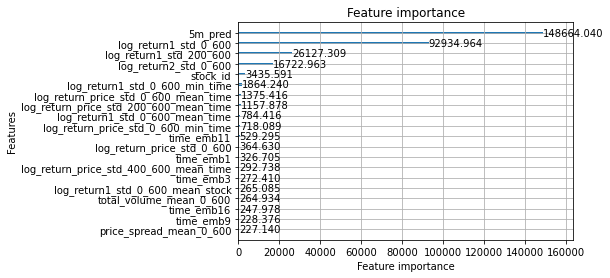

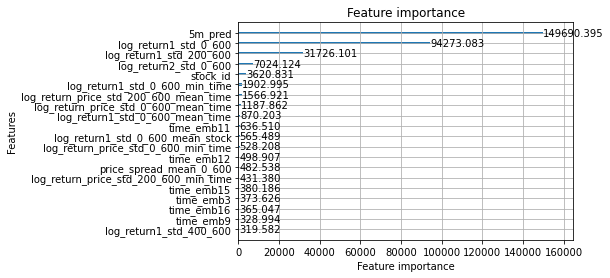

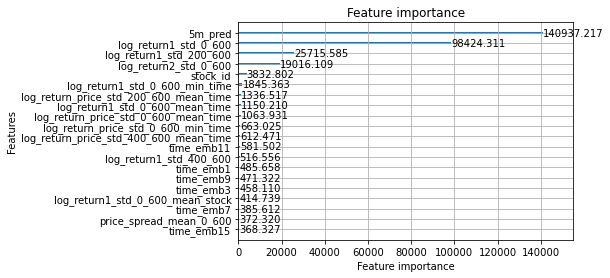

In [63]:
for m in models[:3]:
    lgb.plot_importance(m, max_num_features=20, importance_type='gain')

## Train NN

In [65]:
def rmspe(preds, targs):
    x = (targs-preds)/targs
    return (x**2).mean().sqrt()

In [88]:
splits = GroupKFold().split(train_10m_with_embs, groups = train_10m_with_embs.time_id)


def train_nn(train_df, test_df, split):
    cont_nn,cat_nn = cont_cat_split(train_df, max_card=9000, dep_var='target')
    cat_nn = []


    procs_nn = [Categorify, FillMissing,Normalize]
    dls = TabularPandas(train_df, procs_nn, cat_nn, cont_nn,
                          splits=split, y_names='target').dataloaders(1024)

 

    config={'ps':[0.5,0,0], }
    learn = tabular_learner(dls, y_range=(0,.1), layers=[200,100,10], 
                            n_out=1, 
                            loss_func = rmspe, 
                            metrics=AccumMetric(rmspe), config=config)

    learn.fit_one_cycle(20, 5e-3, wd=.1)
    
    test_dl = dls.test_dl(test_df)
    preds, _ = learn.get_preds(dl=test_dl)
    score =rmspe_np(test_10m_with_embs.target, preds.view(-1).numpy())
    print(score)
    return preds

In [89]:
preds=[]
for trn_idx, val_idx in splits:
    p = train_nn(train_10m_with_embs, test_10m_with_embs, [list(trn_idx), list(val_idx)])
    preds.append(p)

epoch,train_loss,valid_loss,rmspe,time
0,10.185118,8.314651,8.334529,00:01
1,2.960693,1.580666,1.624444,00:01
2,0.774967,0.615497,0.742002,00:01
3,0.415424,0.411628,0.551282,00:01
4,0.274002,0.240321,0.242221,00:01
5,0.257618,0.237300,0.239419,00:01
6,0.289956,0.244574,0.245892,00:01
7,0.254035,0.226036,0.227543,00:01
8,0.250584,0.224149,0.225568,00:01
9,0.238276,0.221137,0.222588,00:01


0.22104294085065046


epoch,train_loss,valid_loss,rmspe,time
0,10.873946,8.933299,8.952564,00:01
1,3.342137,1.439348,1.513015,00:01
2,0.583473,0.459656,0.781451,00:01
3,0.575315,0.294188,0.313586,00:01
4,0.286071,0.245506,0.247356,00:01
5,0.303972,0.261723,0.264037,00:01
6,0.264755,0.237663,0.240460,00:01
7,0.253930,0.230945,0.232593,00:01
8,0.253759,0.230586,0.232584,00:01
9,0.242753,0.227717,0.229436,00:01


0.22138321130480737


epoch,train_loss,valid_loss,rmspe,time
0,10.530907,8.162070,8.221661,00:01
1,3.129771,1.242875,1.284130,00:01
2,0.799717,0.687735,1.925367,00:01
3,0.935807,0.497127,1.696482,00:01
4,0.288607,0.237926,0.240739,00:01
5,0.259324,0.239487,0.242286,00:01
6,0.260051,0.240427,0.242291,00:01
7,0.253994,0.233943,0.235851,00:01
8,0.253734,0.235911,0.237853,00:01
9,0.253694,0.231948,0.234507,00:01


0.2224861316696845


epoch,train_loss,valid_loss,rmspe,time
0,10.658699,9.317251,9.332030,00:01
1,3.259699,1.566521,1.587735,00:01
2,0.642955,0.469729,0.565833,00:01
3,0.650326,0.314732,0.358313,00:01
4,0.290979,0.246502,0.248760,00:01
5,0.271867,0.242158,0.244951,00:01
6,0.248432,0.241827,0.243909,00:01
7,0.244929,0.231868,0.233784,00:01
8,0.259270,0.233380,0.235699,00:01
9,0.265920,0.235263,0.237316,00:01


0.22160593482608262


epoch,train_loss,valid_loss,rmspe,time
0,11.317140,9.128738,9.155679,00:01
1,3.450321,1.438998,1.499879,00:01
2,0.662181,0.546971,0.554993,00:01
3,0.421047,0.437945,1.001051,00:01
4,0.381662,0.252461,0.254258,00:01
5,0.283022,0.243664,0.245126,00:01
6,0.264039,0.241106,0.242199,00:01
7,0.253135,0.229780,0.231138,00:01
8,0.244488,0.229006,0.230141,00:01
9,0.239398,0.234541,0.235486,00:01


0.2206071408251694


In [90]:
score = rmspe_np(test_10m_with_embs.target,torch.cat(preds, dim=1).mean(dim=1).numpy())

score, (baseline_score-score)/ baseline_score

(0.21994776928969995, 0.03214082020940887)

In [91]:
score = rmspe_np(test_10m_with_embs.target,torch.cat(preds, dim=1).median(dim=1)[0].numpy())

score, (baseline_score-score)/ baseline_score

(0.22031750897093885, 0.03051381600847706)